## Simulations for JASA Paper

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy.interpolate import interp1d

import pandas as pd
import numpy as np
float_formatter = "{:.7f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [2]:
model_ids = ['180703949','170803729','140624423']

In [3]:
def binning(data, bin_width=0.05):
    grb_counts = pd.DataFrame(data)
    grb_counts[0] = grb_counts[0]-grb_counts.loc[0, 0]
    first = 0; last = grb_counts.iloc[-1, 0]

    bins = np.arange(first, last+bin_width, bin_width)
    bin_map = pd.cut(grb_counts[0], bins=bins).apply(lambda I: I.left)
    bin_series = pd.DataFrame(bin_map).groupby(0)[0].count()
    bin_df = pd.DataFrame({'count':bin_series})
    return bin_df

def window_detection(signal, λ, σ=5, hmax=128, spacing='logarithmic'):
    
    if spacing=='logarithmic':
        window_lengths = 2**(np.arange(0, np.ceil(np.log2(hmax)))).astype(int)
    else:
        window_lengths = np.arange(1, hmax+1)
    
    max_threshold=0
    best_window=1
    
    for h in window_lengths:
        
        data = signal.rolling(window=h).mean()
        μ = data/λ
        
        lr_statistic = 2*h*λ*(μ*np.log(μ)-μ+1) * (μ>1)
        
        
        if lr_statistic.max() > max_threshold:
            max_threshold = lr_statistic.max()
            best_window=h
        
    sigma_level = np.sqrt(max_threshold*2)
    return sigma_level

In [4]:
#parameters
num = 0
model_id = model_ids[num]
fluences=np.array([0, 100, 200, 400])
hmax=256
bin_width=0.05


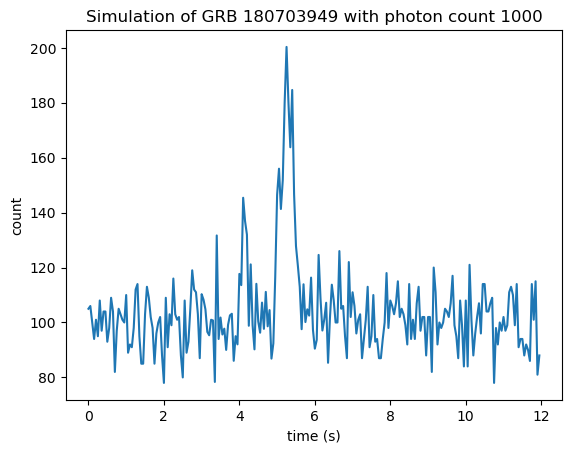

In [5]:
fluence=1000
data = pd.read_csv("simulations.csv", index_col="time") #contains simulations of each burst containing 10000 photons
background = data['background']
burst_shape = data[model_id]
grb = background + fluence/100000 * burst_shape #rescaled model of burst with background
grb.plot()
plt.xlabel('time (s)')
plt.ylabel('count')
plt.title(f'Simulation of GRB {model_id} with photon count {fluence}')
plt.savefig(f'plots/grb{num}_pic.png', dpi=150)


In [8]:
#logarithmic

output = []

for fluence in fluences:

    grb = background + fluence/100000 * burst_shape
    output.append(window_detection(grb, λ=100, hmax=hmax, spacing='logarithmic'))
logarithmic_df = pd.DataFrame({'fluence':fluences, 'mean':output})

#exhaustive

output = []

for fluence in fluences:

    grb = background + fluence/100000 * burst_shape
    output.append(window_detection(grb, λ=100, hmax=hmax, spacing='exhaustive'))

exhaustive_df = pd.DataFrame({'fluence':fluences, 'mean':output})


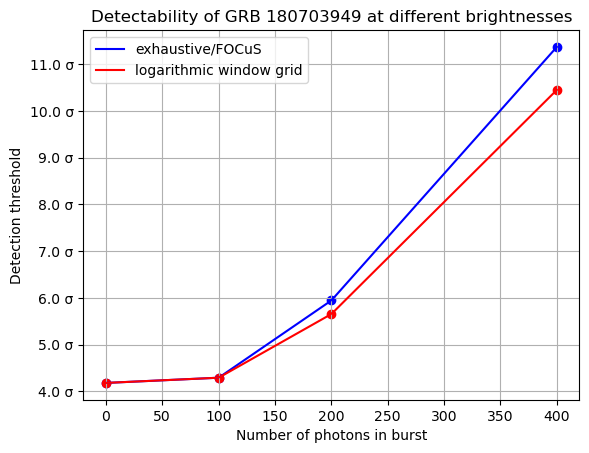

In [11]:
#plotting
interpolation='linear'

plt.scatter(exhaustive_df['fluence'], exhaustive_df['mean'], color='blue')
fit = interp1d(exhaustive_df['fluence'], exhaustive_df['mean'], kind=interpolation)
x=np.linspace(exhaustive_df['fluence'][0], exhaustive_df['fluence'][len(fluences)-1], 100)
plt.plot(x, fit(x), color='blue', label='exhaustive/FOCuS')

plt.scatter(logarithmic_df['fluence'], logarithmic_df['mean'], color='red')
fit = interp1d(logarithmic_df['fluence'], logarithmic_df['mean'], kind=interpolation)
x=np.linspace(logarithmic_df['fluence'][0], logarithmic_df['fluence'][len(fluences)-1], 100)
plt.plot(x, fit(x), color='red', label='logarithmic window grid')

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f σ'))
plt.title(f'Detectability of GRB {model_id} at different brightnesses')
plt.ylabel('Detection threshold')
plt.xlabel('Number of photons in burst')
plt.legend()

plt.grid(True)
plt.savefig(f'plots/grb{num}_sim.png', dpi=150)
plt.show()

140